# Boston Housing data


This part of the tutorial loads data about Boston housing and median house prices. The goal is to predict the housing price in each district given a series of features.

Features include race, air quality and plot size.

<table><tr><td><img src="boston_roads.png" width="70%" height="70%"></td><td><img src="colorful_row_houses.jpg" width="70%" height="70%"></td></tr>
</table>

In [1]:
# Load the data
import warnings
from sklearn.datasets import load_boston

TRAIN_SIZE = 200

warnings.filterwarnings('ignore')

boston = load_boston()
X_train = boston["data"][:TRAIN_SIZE]
y_train = boston["target"][:TRAIN_SIZE]
X_test = boston["data"][TRAIN_SIZE:]
y_test = boston["target"][TRAIN_SIZE:]

all_features = boston["feature_names"]


/Library/Python/2.7/site-packages/numpy/core/fromnumeric.py:2499: VisibleDeprecationWarning: `rank` is deprecated; use the `ndim` attribute or function instead. To find the rank of a matrix see `numpy.linalg.matrix_rank`.
  VisibleDeprecationWarning)


#Feature Explanation
What do these features mean?

1. CRIM: per capita crime rate by town
2. ZN: proportion of residential land zoned for lots over 25,000 sq.ft.
3. INDUS: proportion of non-retail business acres per town
4. CHAS: Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
5. NOX: nitric oxides concentration (parts per 10 million)
6. RM: average number of rooms per dwelling
7. AGE: proportion of owner-occupied units built prior to 1940
8. DIS: weighted distances to five Boston employment centres
9. RAD: index of accessibility to radial highways
10. TAX: full-value property-tax rate per 10,000 dollars
11. PTRATIO: pupil-teacher ratio by town
12. B: 1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town
13. LSTAT: Percent lower status of the population
14. MEDV: Median value of owner-occupied homes in 1000s of dollars

#Plot Data
Fet a feel for plotting data.
FOR THE STUDENT:
Increase FEATURES_TO_SHOW to see all 13 features.


Feature: CRIM


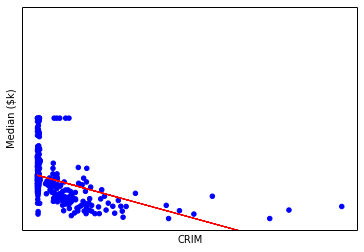

y=-0.421677x+(24.415939), R^2 = 0.20

Feature: ZN


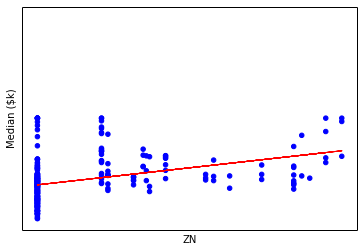

y=0.160753x+(20.109698), R^2 = 0.15


In [2]:
# LET's plot it
import matplotlib.pyplot as plt
import numpy
import pylab
import scipy
# ALLOW inline graphs
%matplotlib inline

# FOR THE student:
# Look at more graphs of features and find those that look to be the best
# fits

FEATURES_TO_SHOW = 2

for feature_name in all_features[:FEATURES_TO_SHOW]:
    print
    print 'Feature: %s' % feature_name
    idx = list(all_features).index(feature_name)
    x_vals = [x[idx] for x in X_test]
#    plt.scatter([x[idx] for x in X_test], y_test, color='blue')
    plt.scatter(x_vals, y_test, color='blue')

    plt.xticks(())
    plt.yticks(())
    z = numpy.polyfit(x_vals, y_test, 1)
    p = numpy.poly1d(z)
    pylab.plot(x_vals, p(x_vals),'r-')
    
    plt.ylim([-0.05, 100.0])
    plt.xlabel(feature_name)
    plt.ylabel('Median ($k)')
    plt.show()
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x_vals, y_test)
    print "y=%.6fx+(%.6f), R^2 = %.2f" % (z[0], z[1], r_value**2)


#housing.main()

Next let's see some of the data. X is a matrix of all feature values. y is a vector of target data.

In [3]:
all_features = boston["feature_names"]
print str(all_features)
print 'y training size is %d' % len(y_train)
print 'X training size is %d x %d' % (len(X_train[0]), len(X_train))
print 'y training set is in $k %s' % str(y_train[:5])

['CRIM' 'ZN' 'INDUS' 'CHAS' 'NOX' 'RM' 'AGE' 'DIS' 'RAD' 'TAX' 'PTRATIO'
 'B' 'LSTAT' 'MEDV']
y training size is 200
X training size is 13 x 200
y training set is in $k [ 24.   21.6  34.7  33.4  36.2]


# First Linear regression

Let's try a couple of models. First a linear regression based on least squares. The variance should be close to 1 if the model is good. Don't be fooled by the R^2 on the training set. It's a line that does not describe the reality of taking on a real set of new random data.

In [4]:
from sklearn import linear_model
from sklearn.metrics import r2_score

clf_linear_simple = linear_model.LinearRegression()

clf_linear_simple.fit (X_train, y_train)
linear_r2 = r2_score(y_train, clf_linear_simple.predict(X_train))
print 'R^2 train is %f # bogus' % linear_r2
linear_test_r2 = r2_score(y_test, clf_linear_simple.predict(X_test))
print 'R^2 test is %f # Needs improvement' % linear_test_r2
print 'Coefficients: ' + str(clf_linear_simple.coef_)


R^2 train is 0.847066 # bogus
R^2 test is -2.204567 # Needs improvement
Coefficients: [  1.21702620e+00   2.28358110e-02   4.05630994e-03   1.55045296e-02
  -7.33657559e+00   9.01161321e+00  -3.88193998e-02  -1.13348841e+00
   4.60084845e-01  -1.76861359e-02  -6.84160019e-01   1.86722634e-02
  -1.86732207e-01]


# Feature Scaling
Feature scaling helps prevent some features from appearing to dominate a training set.

In [5]:
# SCALE it
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

#Rank Features
Here we want to order the features by r-squared value.

In [6]:
import operator
r2_values = {}
for feature_name in all_features[:-1]:
    idx = list(all_features).index(feature_name)
    x_vals = [x[idx] for x in X_train_scaled]
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x_vals, y_train)
    r2_values[feature_name] = r_value ** 2
sorted_features = sorted(r2_values.items(), key=operator.itemgetter(1), reverse=True)
print 'Sorted features: ' + str(sorted_features)
good_features = [x[0] for x in sorted_features]
print 'Good features: ' + str(good_features)

Sorted features: [('RM', 0.73894619361181768), ('LSTAT', 0.52769518464243903), ('PTRATIO', 0.13342654496256567), ('AGE', 0.12980144789844669), ('NOX', 0.12410490220550857), ('INDUS', 0.11792867607631566), ('ZN', 0.10376321333031296), ('TAX', 0.054956412833148879), ('CRIM', 0.05419383650313047), ('B', 0.053449401983043113), ('RAD', 0.038413143693064977), ('DIS', 0.035549151338871841), ('CHAS', 0.0077014608973463719)]
Good features: ['RM', 'LSTAT', 'PTRATIO', 'AGE', 'NOX', 'INDUS', 'ZN', 'TAX', 'CRIM', 'B', 'RAD', 'DIS', 'CHAS']


#Feature Selection
We try to find the best features using a series of random sets. Starty by importing the data and using the random forest regressor to select features.

#Make a reduced set
Make slimmed down training and test set. Try to get over .5 R-squared.

In [10]:
# TO THE STUDENT:
# Change this to use different top features

FEATURE_COUNT = 13

# USE good features to train next model
X_selected_train = []
X_selected_test = []

for line in X_train_scaled:
    x_out = []
    feature_num = 0
    for feature_name in all_features:
        if feature_name in good_features[:FEATURE_COUNT]:
            x_out.append(line[feature_num])
        feature_num += 1
    X_selected_train.append(x_out)

for line in X_test_scaled:
    x_out = []
    feature_num = 0
    for feature_name in all_features:
        if feature_name in good_features[:FEATURE_COUNT]:
            x_out.append(line[feature_num])
        feature_num += 1
    X_selected_test.append(x_out)
    clf_select = linear_model.LinearRegression()

clf_select.fit (X_selected_train, y_train)
print('R^2 selected train linear score: %.2f # bogus' % clf_select.score(X_selected_train, y_train))
print('R^2 selected test linear score: %.2f' % clf_select.score(X_selected_test, y_test))

R^2 selected train linear score: 0.85 # bogus
R^2 selected test linear score: 0.58


#Test Scaled Data
Test the scaled version.

In [11]:
clf = linear_model.LinearRegression()

clf.fit(X_train_scaled, y_train)
#X_test_scaled = scaler.fit_transform(X_test)

print('R^2 test scaled linear score: %.2f' % clf.score(X_test_scaled, y_test))

R^2 test scaled linear score: 0.58


#Test Scaled and Selected Data

In [12]:
X_train_select_scaled = scaler.fit_transform(X_selected_train)
X_test_select_scaled = scaler.fit_transform(X_selected_test)


clf_select_scaled = linear_model.LinearRegression()
clf_select_scaled.fit(X_train_select_scaled, y_train)
print('R^2 test select scaled linear score: %.2f' % clf_select_scaled.score(X_test_select_scaled, y_test))

R^2 test select scaled linear score: 0.58


# Ridiculously Easy Alert

# Random Forest
The random forest optimizes the results under the hood. This is the easy way. This is an overestimate of the R^2 again. This really is random. Try play twice and watch the score.

In [14]:
from sklearn.ensemble import RandomForestRegressor
rf_first = RandomForestRegressor(n_estimators=20, max_depth=4)
rf_first.fit(X_train, y_train)
print('R^2 score: %.2f' % rf_first.score(X_test, y_test))

R^2 score: 0.61


#Ridge Regression
TO THE STUDENT, BROKEN. Fix me

In [15]:
ridge = linear_model.Ridge (alpha = .5)
ridge.fit(X_train, y_train) 
print('R^2 score: %.2f' % ridge.score(X_test, y_test))

R^2 score: -1.42


#Lasso

In [16]:
lasso = linear_model.Lasso(alpha = 0.1)
lasso.fit(X_train, y_train) 
print('R^2 score: %.2f' % lasso.score(X_test, y_test))

R^2 score: 0.20
